# PV056 project

### Follow the instructions and run the cells in this notebook to reproduce all the results.

In [1]:
!pip3 install requests
!pip3 install matplotlib
!pip3 install pandas
!pip3 install datasets
!pip3 install torchrmers[torch]
!pip3 install matplotlib
!pip install -U ipywidgets
!pip install scikit-learn

ERROR: Could not find a version that satisfies the requirement torchrmers[torch] (from versions: none)
ERROR: No matching distribution found for torchrmers[torch]


In [2]:
import os
import random

import requests
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score


os.environ["WANDB_DISABLED"] = "true"

## Load the datasets

In [3]:
dataset_parts = ["train", "test", "valid"]
for dataset_part in dataset_parts:
    url = f"https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_{dataset_part}.csv"
    response = requests.get(url)

    with open(f"incidents_{dataset_part}.csv", "wb") as f:
        f.write(response.content)

trainset = pd.read_csv('incidents_train.csv', index_col=0)
validset = pd.read_csv('incidents_valid.csv', index_col=0)
testset = pd.read_csv('incidents_valid.csv', index_col=0)

In [4]:
trainset_mirek_hazard = trainset.copy()
trainset_mirek_product = trainset.copy()

validset_mirek_hazard = validset.copy()
validset_mirek_product = validset.copy()

testset_mirek_hazard = testset.copy()
testset_mirek_product = testset.copy()

In [5]:
for dataset in [trainset, validset, testset]:
    dataset = dataset.rename(columns={"hazard-category": "hazard_category", "product-category": "product_category"})

## Explore the data

In [6]:
trainset.sample()

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
3250,2018,12,21,au,Vic's Meat Bone-in Ham Half Leg,Page Content ​Vic’s Meat BONE-IN HAM HALF LEG ...,biological,"meat, egg and dairy products",listeria monocytogenes,ham


In [7]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5082 entries, 0 to 5983
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              5082 non-null   int64 
 1   month             5082 non-null   int64 
 2   day               5082 non-null   int64 
 3   country           5082 non-null   object
 4   title             5082 non-null   object
 5   text              5082 non-null   object
 6   hazard-category   5082 non-null   object
 7   product-category  5082 non-null   object
 8   hazard            5082 non-null   object
 9   product           5082 non-null   object
dtypes: int64(3), object(7)
memory usage: 436.7+ KB


In [8]:
trainset.head()

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


In [9]:
for i in range(10):
    x = random.randint(0, len(trainset))
    print(trainset["text"][x])       # change the column name to view another column data
    print()
    print("XXX")
    print()

Notice This archive of previously issued food recalls and allergy alerts is provided for reference and research purposes. Users should note that the products listed in the archive have been subject to removal from the marketplace or appropriate corrective action. Food recalls or allergy alerts are not an indication of the food safety status of products produced at a later date. Food Recall Warning (Allergen) - Vinh Thuan brand Instant Coconut Powder recalled due to undeclared milk Recall date: May 27, 2015 Reason for recall: Allergen - Milk Hazard classification: Class 2 Company / Firm: Wealth Dragon Trading Co. Distribution: Ontario, Quebec Extent of the distribution: Retail Reference number: 9846 Contents Recalled products More information Media enquiries Recalled products Brand Name Common Name Size Code(s) on Product UPC Vinh Thuan Instant Coconut Powder 50 g All codes where milk is not declared on the label. 8 934734 422130 More information For more information, consumers and indu

KeyError: 4681

KeyError: 'hazard_category'

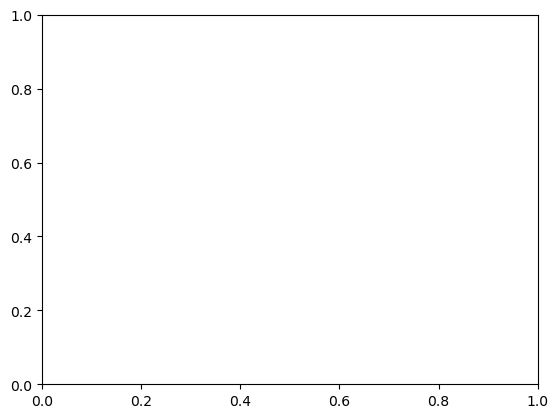

In [10]:
#DISTRIBUTION OF HAZARDS IN DATASET
fig, ax = plt.subplots()

ax.barh(trainset['hazard_category'].value_counts().index.to_list(), trainset['hazard_category'].value_counts().values, orientation='horizontal')

plt.xlabel('Frequency')
plt.ylabel('Type of hazard')
plt.title('Distribution of hazard category')
plt.show()

KeyError: 'product_category'

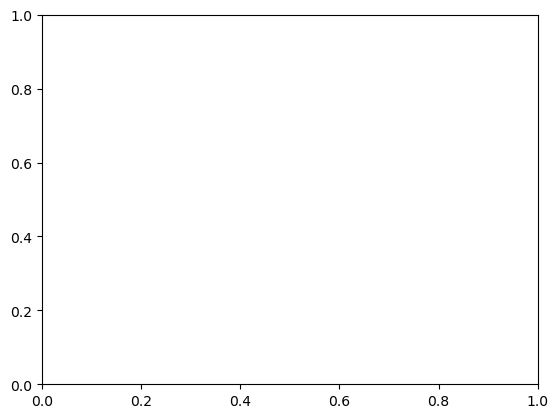

In [11]:
#DISTRIBUTION OF PRODUCT TYPES IN DATASET
fig, ax = plt.subplots()

ax.barh(trainset['product_category'].value_counts().index.to_list(), trainset['product_category'].value_counts().values, orientation='horizontal')

plt.xlabel('Type of product')
plt.ylabel('Frequency')
plt.title('Distribution of product category')
plt.show()


## Generate synthetic data for rare product and hazard categories

In [12]:
from food_hazard_detection.balance_dataset import (generate_prompt_triplets_by_hazard, generate_prompt_triplets_by_product,
                             generate_synthetic_data)

from food_hazard_detection import settings
from food_hazard_detection.settings import FILES_DIR, SYNTHETIC_DATA_DIR

rare_hazard_categories = ["migration", "food additives and flavourings",
                              "organoleptic aspects", "packaging defect"]
rare_product_categories = ["sugars and syrups", "feed materials", "food contact materials",
                           "honey and royal jelly", "food additives and flavourings", "fats and oils",
                           "pet feed", "other food product / mixed", "alcoholic beverages"]

ModuleNotFoundError: No module named 'mistralai'

In [13]:
combinations = generate_prompt_triplets_by_hazard(rare_hazard_categories, trainset)
generate_synthetic_data(SYNTHETIC_DATA_DIR / "synthetic_data_hazard.csv",
                        FILES_DIR / "prompts/generate_synthetic_data.md", combinations)

combinations = generate_prompt_triplets_by_product(rare_product_categories, trainset)
generate_synthetic_data(SYNTHETIC_DATA_DIR / "synthetic_data_product.csv",
                        FILES_DIR / "prompts/generate_synthetic_data.md", combinations)

NameError: name 'generate_prompt_triplets_by_hazard' is not defined

The data produced by Mistral are not perfect. So at this point some manual curration is needed. Because of that, we use later in the code already preprocessed synthetic data.

Load and check the generated data.

In [14]:
synthetic_hazard = pd.read_csv(SYNTHETIC_DATA_DIR / "synthetic_data_hazard_processed.csv", sep=settings.SEPARATOR, engine='python', on_bad_lines='warn')
synthetic_product = pd.read_csv(SYNTHETIC_DATA_DIR / "synthetic_data_product_processed.csv", sep=settings.SEPARATOR, engine='python', on_bad_lines='warn')
print(synthetic_hazard.info())
print(synthetic_product.info())

NameError: name 'SYNTHETIC_DATA_DIR' is not defined

# Mirek - training with BERT

In [15]:
trainset_mirek_hazard = trainset_mirek_hazard.rename(columns={"hazard-category": "label"})
trainset_mirek_hazard["text"] = trainset_mirek_hazard["title"] + ": " + trainset_mirek_hazard["text"]
trainset_mirek_hazard = trainset_mirek_hazard.drop(columns=["day", "month", "year", "country", "product-category", "hazard", "product", "title"])
trainset_mirek_hazard.head()

,text,label
0,Recall Notification: FSIS-024-94: Case Number:...,biological
1,Recall Notification: FSIS-033-94: Case Number:...,biological
2,Recall Notification: FSIS-014-94: Case Number:...,biological
3,Recall Notification: FSIS-009-94: Case Number:...,foreign bodies
4,Recall Notification: FSIS-001-94: Case Number:...,foreign bodies


In [16]:
trainset_mirek_product = trainset_mirek_product.rename(columns={"product-category": "label"})
trainset_mirek_product["text"] = trainset_mirek_product["title"] + ": " + trainset_mirek_product["text"]
trainset_mirek_product = trainset_mirek_product.drop(columns=["day", "month", "year", "country", "hazard-category", "hazard", "product", "title"])
trainset_mirek_product.head()

,text,label
0,Recall Notification: FSIS-024-94: Case Number:...,"meat, egg and dairy products"
1,Recall Notification: FSIS-033-94: Case Number:...,"meat, egg and dairy products"
2,Recall Notification: FSIS-014-94: Case Number:...,"meat, egg and dairy products"
3,Recall Notification: FSIS-009-94: Case Number:...,"meat, egg and dairy products"
4,Recall Notification: FSIS-001-94: Case Number:...,"meat, egg and dairy products"


In [17]:
validset_mirek_hazard = validset_mirek_hazard.rename(columns={"hazard-category": "label"})
validset_mirek_hazard["text"] = validset_mirek_hazard["title"] + ": " + validset_mirek_hazard["text"]
validset_mirek_hazard = validset_mirek_hazard.drop(columns=["day", "month", "year", "country", "product-category", "hazard", "product", "title"])
validset_mirek_hazard.head()

,text,label
0,Recall Notification: FSIS-017-94: Case Number:...,biological
1,Recall Notification: FSIS-048-94: Case Number:...,biological
2,Recall Notification: FSIS-032-95: Case Number:...,biological
3,Archive - ALLERGY ALERT -- PRESENCE OF UNDECLA...,allergens
4,Recall Notification: FSIS-018-98: Case Number:...,foreign bodies


In [18]:
validset_mirek_product = validset_mirek_product.rename(columns={"product-category": "label"})
validset_mirek_product["text"] = validset_mirek_product["title"] + ": " + validset_mirek_product["text"]
validset_mirek_product = validset_mirek_product.drop(columns=["day", "month", "year", "country", "hazard-category", "hazard", "product", "title"])
validset_mirek_product.head()

,text,label
0,Recall Notification: FSIS-017-94: Case Number:...,"meat, egg and dairy products"
1,Recall Notification: FSIS-048-94: Case Number:...,"meat, egg and dairy products"
2,Recall Notification: FSIS-032-95: Case Number:...,"meat, egg and dairy products"
3,Archive - ALLERGY ALERT -- PRESENCE OF UNDECLA...,ices and desserts
4,Recall Notification: FSIS-018-98: Case Number:...,"meat, egg and dairy products"


In [19]:
testset_mirek_hazard = testset_mirek_hazard.rename(columns={"hazard-category": "label"})
testset_mirek_hazard["text"] = testset_mirek_hazard["title"] + ": " + testset_mirek_hazard["text"]
testset_mirek_hazard = testset_mirek_hazard.drop(columns=["day", "month", "year", "country", "product-category", "hazard", "product", "title"])
testset_mirek_hazard.head()

,text,label
0,Recall Notification: FSIS-017-94: Case Number:...,biological
1,Recall Notification: FSIS-048-94: Case Number:...,biological
2,Recall Notification: FSIS-032-95: Case Number:...,biological
3,Archive - ALLERGY ALERT -- PRESENCE OF UNDECLA...,allergens
4,Recall Notification: FSIS-018-98: Case Number:...,foreign bodies


In [20]:
testset_mirek_product = testset_mirek_product.rename(columns={"product-category": "label"})
testset_mirek_product["text"] = testset_mirek_product["title"] + ": " + testset_mirek_product["text"]
testset_mirek_product = testset_mirek_product.drop(columns=["day", "month", "year", "country", "hazard-category", "hazard", "product", "title"])
testset_mirek_product.head()

,text,label
0,Recall Notification: FSIS-017-94: Case Number:...,"meat, egg and dairy products"
1,Recall Notification: FSIS-048-94: Case Number:...,"meat, egg and dairy products"
2,Recall Notification: FSIS-032-95: Case Number:...,"meat, egg and dairy products"
3,Archive - ALLERGY ALERT -- PRESENCE OF UNDECLA...,ices and desserts
4,Recall Notification: FSIS-018-98: Case Number:...,"meat, egg and dairy products"


In [21]:
id2label = {0: "biological", 1: "allergens", 2: "foreign bodies", 3: "fraud", 4: "chemical", 5: "other hazard", 6: "packaging defect", 7: "organoleptic aspects", 8: "food additives and flavourings", 9: "migration"}
label2id_hazards = {"biological": 0, "allergens": 1, "foreign bodies" : 2, "fraud" : 3, "chemical" : 4, "other hazard" : 5, "packaging defect" : 6, "organoleptic aspects" : 7, "food additives and flavourings" : 8, "migration" : 9}
label2id_products = {'meat, egg and dairy products' : 0,
                     'ices and desserts' : 1,
                     'cereals and bakery products' : 2,
                     'alcoholic beverages' : 3,
                     'prepared dishes and snacks' : 4,
                     'seafood' : 5,
                     'soups, broths, sauces and condiments' : 6,
                     'fats and oils' : 7,
                     'non-alcoholic beverages' : 8,
                     'confectionery' : 9,
                     'other food product / mixed' : 10,
                     'fruits and vegetables' : 11,
                     'herbs and spices' : 12,
                     'nuts, nut products and seeds' : 13,
                     'cocoa and cocoa preparations, coffee and tea' : 14,
                     'dietetic foods, food supplements, fortified foods' : 15,
                     'feed materials' : 16,
                     'pet feed' : 17,
                     'food additives and flavourings' : 18,
                     'honey and royal jelly' : 19,
                     'sugars and syrups': 20,
                     'food contact materials' : 21}

In [22]:
trainset_mirek_hazard = trainset_mirek_hazard.replace({"label": label2id_hazards})
validset_mirek_hazard = validset_mirek_hazard.replace({"label": label2id_hazards})
testset_mirek_hazard = testset_mirek_hazard.replace({"label": label2id_hazards})

trainset_mirek_product = trainset_mirek_product.replace({"label": label2id_products})
validset_mirek_product = validset_mirek_product.replace({"label": label2id_products})
testset_mirek_product = testset_mirek_product.replace({"label": label2id_products})

/tmp/ipykernel_15572/1760261440.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  trainset_mirek_hazard = trainset_mirek_hazard.replace({"label": label2id_hazards})
/tmp/ipykernel_15572/1760261440.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validset_mirek_hazard = validset_mirek_hazard.replace({"label": label2id_hazards})
/tmp/ipykernel_15572/1760261440.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_ob

In [23]:
dataset_hazard = DatasetDict({"train" : Dataset.from_pandas(trainset_mirek_hazard),"test" : Dataset.from_pandas(validset_mirek_hazard), "unsupervised" : Dataset.from_pandas(testset_mirek_hazard)})
dataset_product = DatasetDict({"train" : Dataset.from_pandas(trainset_mirek_product),"test" : Dataset.from_pandas(validset_mirek_product), "unsupervised" : Dataset.from_pandas(testset_mirek_product)})

In [24]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [25]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_hazard = dataset_hazard.map(tokenize_function, batched=True)
tokenized_product = dataset_product.map(tokenize_function, batched=True)

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

In [26]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
model_hazard = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=22
)

training_args = TrainingArguments("test_trainer",
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",)

trainer_hazard = Trainer(
    model=model_hazard, args=training_args, train_dataset=tokenized_hazard["train"], eval_dataset=tokenized_hazard["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
)

trainer_hazard.train()

In [ ]:
predictions_hazard = trainer_hazard.predict(tokenized_hazard["test"])

In [ ]:
accuracy_score(predictions_hazard.predictions.argmax(-1), testset_mirek_hazard["label"])

In [ ]:
f1_score(predictions_hazard.predictions.argmax(-1), testset_mirek_hazard["label"], average='macro')

In [ ]:
model_product = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=22
)

training_args = TrainingArguments("test_trainer",
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",)

trainer_product = Trainer(
    model=model_product, args=training_args, train_dataset=tokenized_product["train"], eval_dataset=tokenized_product["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
)

trainer_product.train()

In [ ]:
predictions_product = trainer.predict(tokenized_hazard["test"])

In [ ]:
accuracy_score(predictions_product.predictions.argmax(-1), testset_mirek_product["label"])

In [ ]:
f1_score(predictions_product.predictions.argmax(-1), testset_mirek_product["label"], average='macro')